In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bss

plt.rcParams.update({'font.size': 14})

## Independant Component Analysis
This is a statistical method. 

<u>Hypotheses:</u> 
- the sources are random and independant,
- at most one source is Gaussian.

Let us generate the data. We consider here two sources with different distributions.

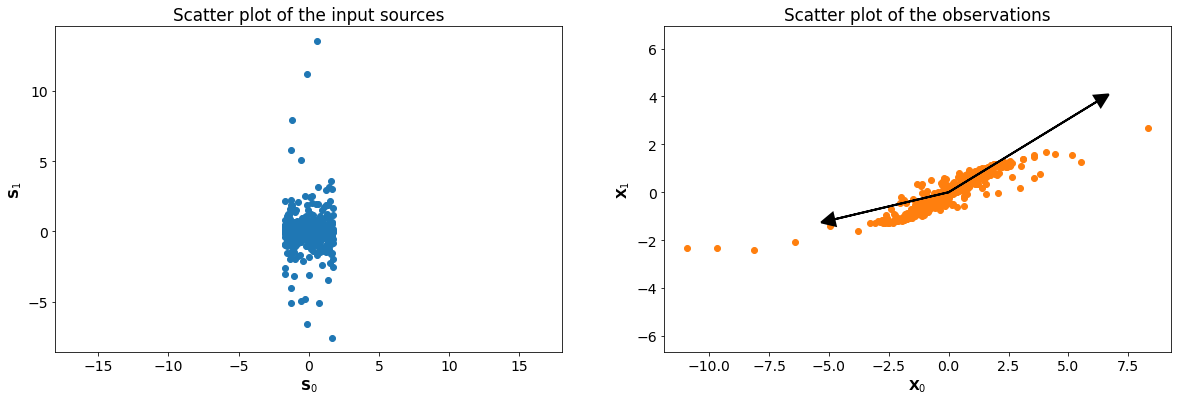

In [19]:
# Generate data

n = 2         # number of sources
m = 2         # number of observations
t = 1024      # number of samples

s_type = [2, 3]    # uniform and sparse random sources

X, A, S = bss.makeMixture(s_type=s_type, n=n, m=m, t=t)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the observations')
vrange = 0.5*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

The central limit theorem states that the properly normalized sum of independant random variables tends towards a normal distribution. 

In the context of BSS, mixing the sources tend to "gaussianize" the observations. To illustrate this, below are the histograms of the sources and the observations. The effect of the "gaussianization" here is quite limitied because there are only two sources.

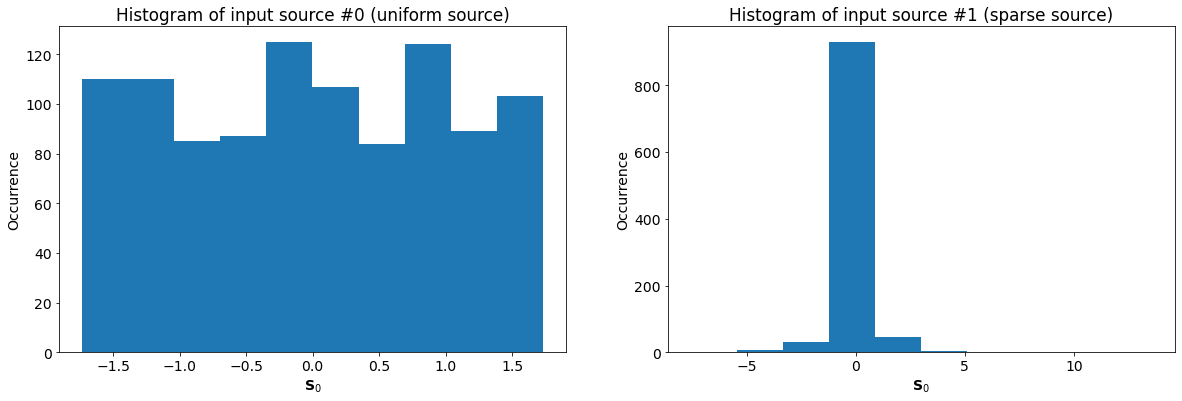

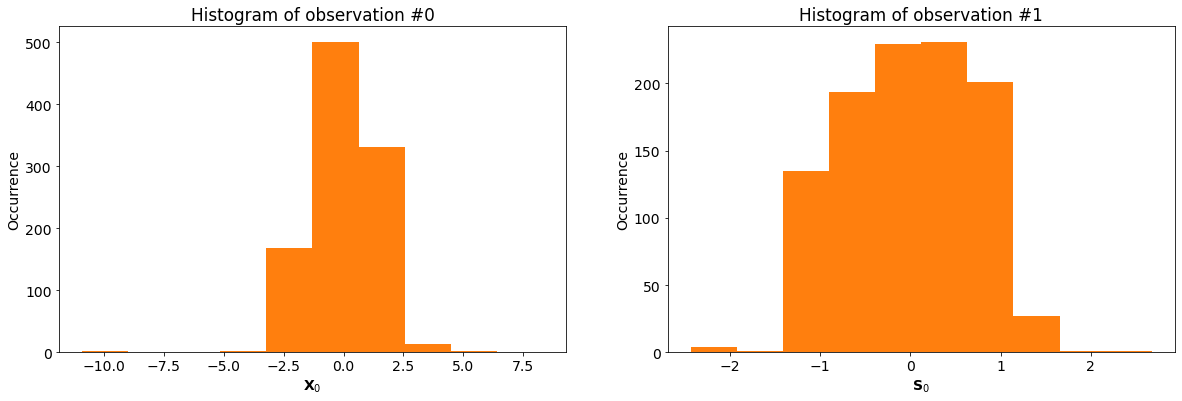

In [20]:
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.hist(S[0, :], color='C0')
plt.xlabel('$\mathbf{S}_0$')
plt.ylabel('Occurrence')
plt.title('Histogram of input source #0 (uniform source)');
fig.add_subplot(1,2,2)
plt.hist(S[1, :], color='C0')
plt.xlabel('$\mathbf{S}_0$')
plt.ylabel('Occurrence')
plt.title('Histogram of input source #1 (sparse source)');
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.hist(X[0, :], color='C1')
plt.xlabel('$\mathbf{X}_0$')
plt.ylabel('Occurrence')
plt.title('Histogram of observation #0');
fig.add_subplot(1,2,2)
plt.hist(X[1, :], color='C1')
plt.xlabel('$\mathbf{S}_0$')
plt.ylabel('Occurrence')
plt.title('Histogram of observation #1');

The basic idea of ICA is to use the non-gaussianity of the sources as a proxy for their independance; in other words, the "non-gaussianity" of the sources is maximized in ICA.

Several ICA methods exist, they differ on the kind of measure of independance. We can cite:
- infomax (minimize the mutual information between the sources),
- JADE (diagonalize the 4th order cumulant tensor of the sources),
- FastICA (maximize the negentropy of the sources).

Let us test FastICA.

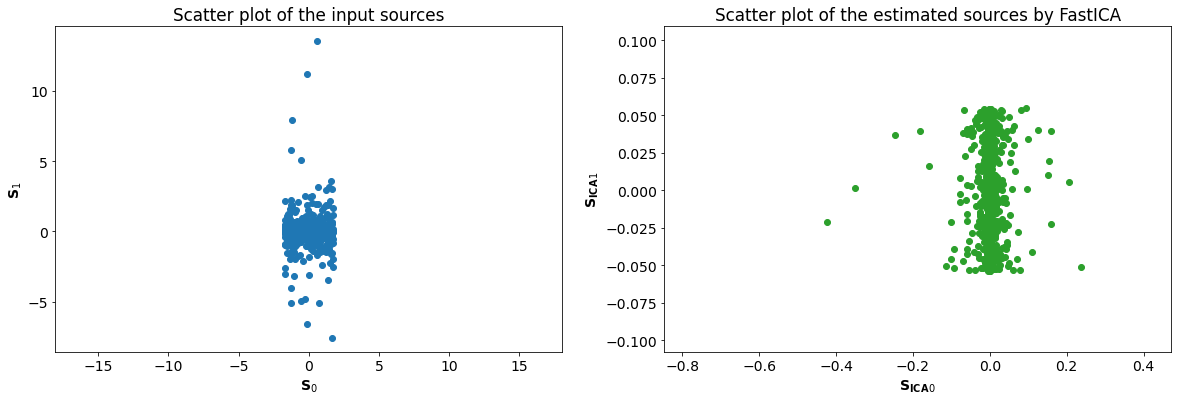

In [21]:
# Unmix sources with FastICA

A_fpica,S_fpica = bss.fastica(X,n)

S_fpica = np.linalg.pinv(A_fpica)@X

S_fpica = np.diag(1/np.sqrt(np.sum(S_fpica**2,axis=1)))@S_fpica

Mrange = 2*np.max(S_fpica,1)
mrange = 2*np.min(S_fpica,1)
vrange = 0.5*max([max(abs(Mrange)),max(abs(mrange))])

G = np.linalg.pinv(A_fpica)@A

G = np.diag(1./np.sqrt(np.sum(G*G,axis=1)))@G

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by FastICA')
plt.plot(S_fpica[0,:],S_fpica[1,:], 'C2o', zorder=0)
plt.xlabel("$\mathbf{S_{ICA}}_0$")
plt.ylabel("$\mathbf{S_{ICA}}_1$")
plt.axis([mrange[0], Mrange[0], mrange[1], Mrange[1]]);

We can clearly see above the effect the permutation and scale indeterminacies. Indeed:
- the estimated sources are not ordered in the same manner as the input sources,
- the scale of the estimated sources is wrong.

We can use the knowledge of the ground truth sources to solve these indeterminacies.

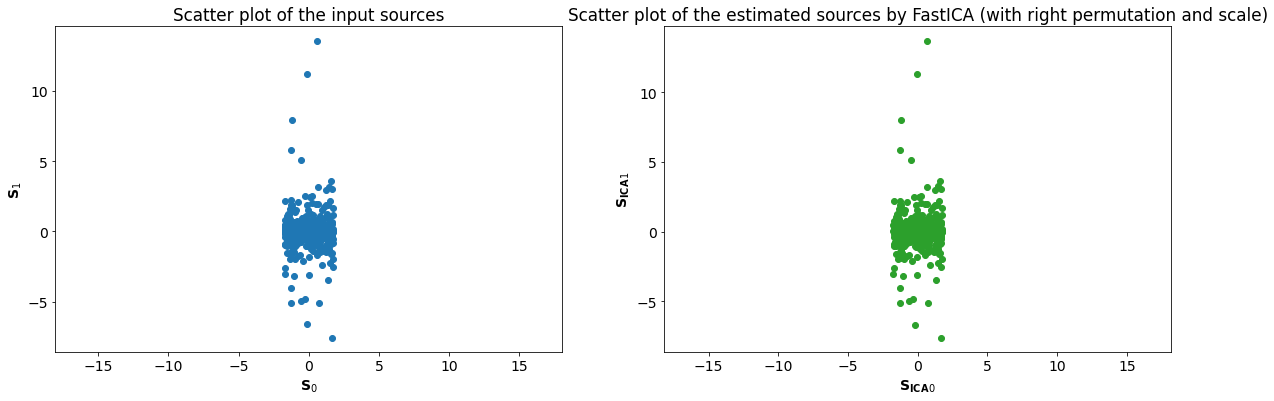

In [22]:
bss.corr_perm(A, S, A_fpica, S_fpica, inplace=True)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by FastICA (with right permutation and scale)')
plt.plot(S_fpica[0,:],S_fpica[1,:], 'C2o', zorder=0)
plt.xlabel("$\mathbf{S_{ICA}}_0$")
plt.ylabel("$\mathbf{S_{ICA}}_1$")
plt.axis('equal');

ICA does not take into account the noise contamination. Consequently, it is not very robust with noise. 

Let us define two performance metrics, which evaluate the reconstruction quality of the estimated sources $\mathbf{\hat{S}}$ and mixing matrix $\mathbf{\hat{A}}$ (the higher, the better):
- $\text{NMSE} = -20 \log{\dfrac{||\mathbf{S}-\mathbf{\hat{S}}||}{||\mathbf{S}||}}$,
- $\text{CA} = -20 \log{\text{mean}(\mathbf{A}^+\mathbf{\hat{A}}-\mathbf{I})}$.

Let us evaluate the evolution of these metrics with respect to the noise level which contaminates the observations.

/Users/rcarlonigert/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/Users/rcarlonigert/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


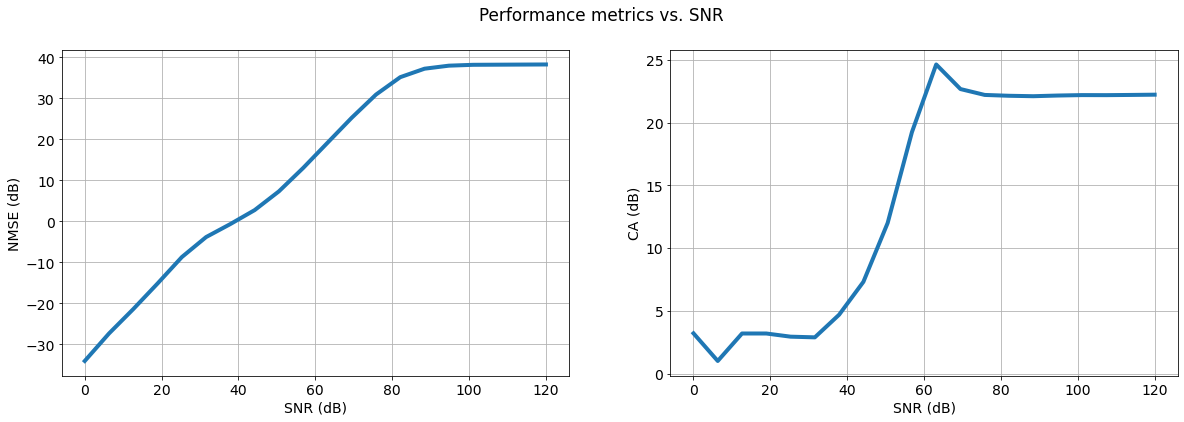

In [23]:
npoints = 20
snrs = np.linspace(0, 120, npoints)
stds = np.linalg.norm(X, 'fro')*10**(-snrs/20)
N = np.random.randn(m, t)
nmses = np.zeros(npoints)
cas = np.zeros(npoints)
for i, std in enumerate(stds):
    Xn = X + std*N
    A_fpica, S_fpica = bss.fastica(Xn, n)
    bss.corr_perm(A, S, A_fpica, S_fpica, inplace=True)
    nmses[i] = bss.nmse(S, S_fpica)
    cas[i] = bss.ca(A, A_fpica)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Performance metrics vs. SNR')
fig.add_subplot(1,2,1)
plt.plot(snrs, nmses, linewidth=4)
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.grid()

fig.add_subplot(1,2,2)
plt.plot(snrs, cas, linewidth=4)
plt.xlabel('SNR (dB)')
plt.ylabel('CA (dB)')
plt.grid()

<b>Next:</b> [4. Non-negative matrix factorization](./4_NonNegative_Matrix_Factorization.ipynb)